In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='33333',
    database='eccomrce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r'C:\Users\Pranav\OneDrive\Desktop\e commrce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "33333",
                            database = "eccomrce")

cur = db.cursor()

## list all unique cities where customres are located



In [5]:
query = """ select distinct (customer_city)from customers"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# count the number of orders is 2017 . 

In [19]:
query = """ select count(order_id) from orders where year (order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
"total orders placed in 2017 are",data[0][0]

('total orders placed in 2017 are', 270606)

# Find the total sales per category. 

In [30]:
query = """ select products.product_category category,sum(payments.payment_value) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data ,columns = ["category","sales"])
df

,category,sales
0,perfumery,5.067387e+05
1,Furniture Decoration,1.430176e+06
2,telephony,4.868821e+05
3,bed table bath,1.712554e+06
4,automotive,8.522943e+05
...,...,...
69,cds music dvds,1.199430e+03
70,La Cuisine,2.913530e+03
71,Fashion Children's Clothing,7.856700e+02
72,PC Gamer,2.174430e+03


# Calculate the percentage of orders that were paid in installments

In [9]:
query = """ select (sum(case when payment_installments >=1 then 1 else 0 end))/count(*)*100 from payments """
cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments",data

('the percentage of orders that were paid in installments',
 [(Decimal('99.9981'),)])

# Count the number of customers from each state

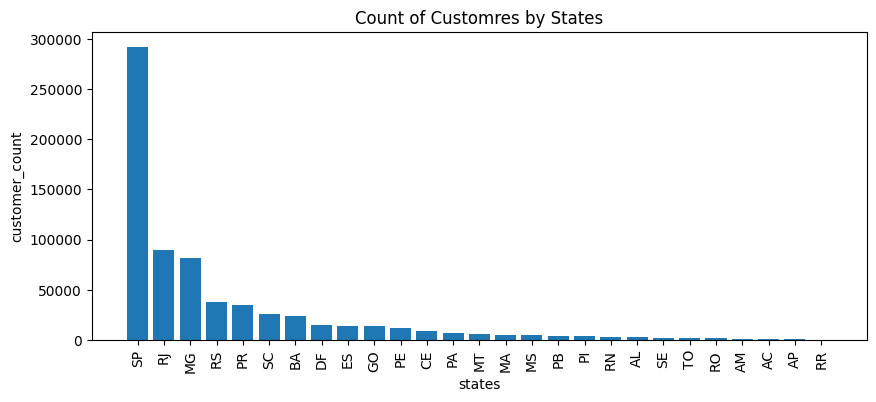

In [37]:
query = """ select customer_state  ,count(customer_id)
from customers group by customer_state"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count"])


plt.figure(figsize= (10,4))
df = df.sort_values(by = "customer_count",ascending= False)
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title('Count of Customres by States')
plt.show()


#   calculated the number of orders of per month in 2018

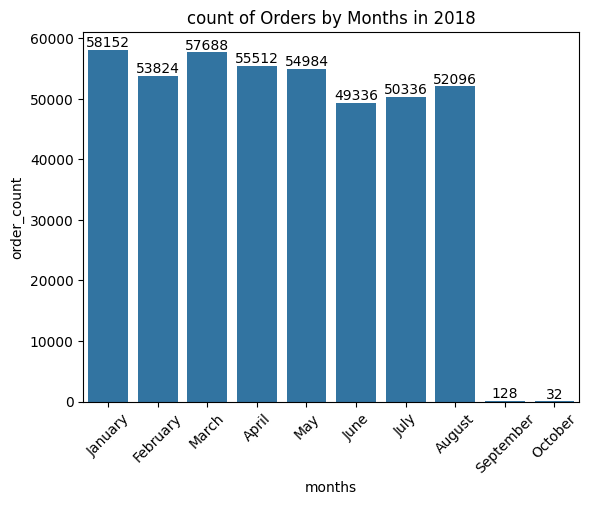

In [6]:
query = """ select monthname (order_purchase_timestamp) months, count(order_id) order_count
from orders where year (order_purchase_timestamp)=2018
group by months """
cur.execute(query)
data = cur.fetchall()
df = pd. DataFrame (data ,columns = ["months", "order_count"])
o = ["January","February","March","April","May","June","July","August","September","October"]


ax=sns.barplot(x=df["months"], y=df["order_count"], data= df, order=o)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("count of Orders by Months in 2018")
plt.show()


#   find the order number of products per order , grouped by the customer city.

In [12]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id)as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2)average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by average_orders desc"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city","average products/orders"])
df.head(10)

,customer city,average products/orders
0,padre carvalho,168.00
1,celso ramos,156.00
2,datas,144.00
3,candido godoi,144.00
4,matias olimpio,120.00
5,cidelandia,96.00
6,curralinho,96.00
7,picarra,96.00
8,morro de sao paulo,96.00
9,teixeira soares,96.00


# calculate the percentage of total revenue contributed by each product category

In [17]:
query = """  select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value)from payments))*100,2)sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc
 """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns =["Category", "percentage distribution"])
df.head(5)

,Category,percentage distribution
0,BED TABLE BATH,96.28
1,HEALTH BEAUTY,93.18
2,COMPUTER ACCESSORIES,89.13
3,FURNITURE DECORATION,80.40
4,WATCHES PRESENT,80.35


# identify the corelation between product price and the number of times has been purchased

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "33333",
                            database = "eccomrce")

cur = db.cursor()
query ="""select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns =["Category", "order_count", "price"])
arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product ha s been purchase is ", a[0][-1])

the correlation between price and number of times a product ha s been purchase is  -0.10631514167157556


# find the average number of products per order , grouped by city .